# Assignment 1
## Roll Number : CS25MTECH02007
## Name : Rajat Maheshwari
<hr>

# Web Scraping, Cleaning, and Text Analysis of [Steam Store Games](https://store.steampowered.com/)

## 📝 Assignment Overview
In this assignment, I will:
1. **Scrape** at least **300 webpages** from the **Steam Store** to collect data about games.
2. **Clean** the scraped data to ensure it is ready for analysis.
3. Perform **text-based analysis** on the cleaned data to extract insights.

# Install Modules

In [1]:
! pip install -r requirements.txt

# Necessary Imports

In [2]:
import os
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import urllib
import unicodedata
import logging
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

## NLTK Downloads

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## NLTK Imports

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Creating Intermediate folders

In [5]:
os.makedirs("html_fetch", exist_ok=True)
os.makedirs("Intermediate", exist_ok=True)

# Creating Helper Functions for life Cycles

## 1) Age Bypass function

In [6]:
def bypass_age(url):
    session = requests.Session()
    check_url = "https://store.steampowered.com/agecheck/app/"
    temp = url.split('/app/')[1]
    app_id = temp.split('/')[0]
    birthday = {
        'ageDay': '6',
        'ageMonth': 'February',
        'ageYear': '1999'
    }
    session.post(f"{check_url}{app_id}/", data=birthday)
    response = session.get(url)
    return response

## 2) Tags collection Function

In [7]:
def fetch_tags(soup):
    try:
        tags_div = soup.find('div', class_='glance_tags popular_tags')
        if not tags_div:
            return "N/A"
        tags = [tag.text.strip() for tag in tags_div.find_all('a', class_='app_tag')]
        logging.debug(f"tags fetched for the game: {tags}")
        return str(tags)  
    except Exception as e:
        logging.error(f"Error fetching tags: {e}")
        return "N/A"

## 3) Fetcher Function

In [8]:
def scrape_games(no_games):
    base_url = "https://store.steampowered.com/search/results/?query&start={}&count=50&filter=topsellers&os=win"
    data = []

    for start in range(0, no_games, 50):  
        url = base_url.format(start)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        games = soup.find_all('a', class_='search_result_row')
        for game in games:
            game_link = game['href']
            if game.find('span', class_='title'):
                title = game.find('span', class_='title').text  
            else:
                title="N/A"
            
            if game.find('div', class_='search_price'): 
                price = game.find('div', class_='search_price').text.strip() 
            else: price = "Free"

            if game.find('div', class_='search_released'):
                release_date = game.find('div', class_='search_released').text.strip() 
            else: release_date = "N/A"

            try:
                if "agecheck" in game_link:
                    response = bypass_age(game_link)
                else:
                    response = requests.get(game_link)
                
                logging.info(f"repsone status code: {response.status_code}")
                with open(f"html_fetch/{title.replace('/', '_')}.html", "w", encoding="utf-8") as file:
                    file.write(response.text)
                    logging.debug(f"file written for the Game {title}")

                game_soup = BeautifulSoup(response.text, 'html.parser')
                description = game_soup.find('div', class_='game_description_snippet')
                if description is not None:
                    description = description.text.strip() 
                else:
                    description = "N/A"
                reviews = game_soup.find('span', class_='nonresponsive_hidden responsive_reviewdesc')
                data.append({'Title': title,'Price': price,'Release Date': release_date,'Tags': fetch_tags(game_soup),'Description': description,'Reviews': reviews,'URL': game_link})

            except Exception as e:
                logging.error(f"Error fetching details for {title}: {e}")

        time.sleep(2) 

    return data

## 4) Cleaner Functions

In [34]:
def clean_text(text):

    cleaned = re.sub(r"[\x00-\x09\x0B\x0C\x0E-\x1F\x7F-\x9F]", " ", text)
    cleaned = unicodedata.normalize("NFKD", cleaned)
    cleaned = cleaned.replace(r"\u2022", "\n- ").replace("\xa0", " ")
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"[^\w\s]", "", cleaned)

    try:
        cleaned = cleaned.encode("ascii", "ignore").decode("utf-8")
    except UnicodeError as e:
        logging.error("Encoding-decoding error: %s", str(e))
        raise UnicodeError("Encoding-decoding error")

    cleaned = re.sub(r"\n{9,}", "\n\n", cleaned)
    cleaned = re.sub(r"\n{3,8}", "\n", cleaned)
    cleaned = re.sub(r"\bgame\b", "", cleaned, flags=re.IGNORECASE) # Game word was over used
    cleaned = re.sub(r"(\s*\n\s*){2,}", "\n\n", cleaned)
    cleaned = cleaned.strip()
    return cleaned


def clean_title(text):

    cleaned = clean_text(text)
    cleaned = urllib.parse.unquote(cleaned)
    cleaned = cleaned.replace("_", " ")
    cleaned = re.sub(" +", " ", cleaned)
    cleaned = cleaned.strip()
    return cleaned

## 5) Analysis Functions

In [35]:
lemmatizer = WordNetLemmatizer()

def stop_words_lemmatize(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [
        lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words
    ]
    return ' '.join(filtered_words)

def tokenize_text(text):
    return word_tokenize(text)

def word_frequency(cleaned_descriptions):
    all_words = ' '.join(cleaned_descriptions).split()
    freq = Counter(all_words)
    df = pd.DataFrame(freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    return df

def convert_to_list(value):
    if isinstance(value, list):  # Already a list
        return value
    else:
        try:
            return eval(value) 
        except (SyntaxError, NameError):
            return []

def tag_frequency(tags_column):
    tags_column = tags_column.apply(convert_to_list)
    tag_list = [tag for tags in tags_column for tag in tags]
    freq = Counter(tag_list)
    
    df = pd.DataFrame(freq.items(), columns=['Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)
    return df

def plot_word_freq(word_freq_df, top_n=10):
    top_words = word_freq_df.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
    plt.title(f'Top {top_n} Word Frequencies in Descriptions')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

def plot_tag_freq(tag_freq_df, top_n=10):
    top_tags = tag_freq_df.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.bar(top_tags['Tag'], top_tags['Frequency'], color='lightgreen')
    plt.title(f'Top {top_n} Tag Frequencies')
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

def analyze_game_data(df, top_n_words=10, top_n_tags=10):
   
    df['Cleaned_Description'] = df['Preprocessed_Description'].apply(stop_words_lemmatize)    
    df['Tokenized_Description'] = df['Cleaned_Description'].apply(tokenize_text)

    word_freq_df = word_frequency(df['Cleaned_Description'])
    tag_freq_df =tag_frequency(df['Tags'])
    plot_word_freq(word_freq_df, top_n=top_n_words)
    plot_tag_freq(tag_freq_df, top_n=top_n_tags)

    return df

## 6) Wordcloud Function

In [45]:
def create_wordcloud(descriptions,title="Descriptions"):
    all_words = ' '.join([' '.join(tokens) for tokens in descriptions])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Game  {title}", fontsize=16)
    plt.show()

# Working with Functions

<b>Scraping might take 8-10 Mins</b>

## scraping data

In [28]:
games_data = scrape_games()
df = pd.DataFrame(games_data)
df.to_csv("Intermediate\\steam_games.csv", index=False)

ERROR:root:Error fetching details for STAR WARS™: Episode I: Jedi Power Battles™: [Errno 22] Invalid argument: 'html_fetch/STAR WARS™: Episode I: Jedi Power Battles™.html'


## word and tag frequency

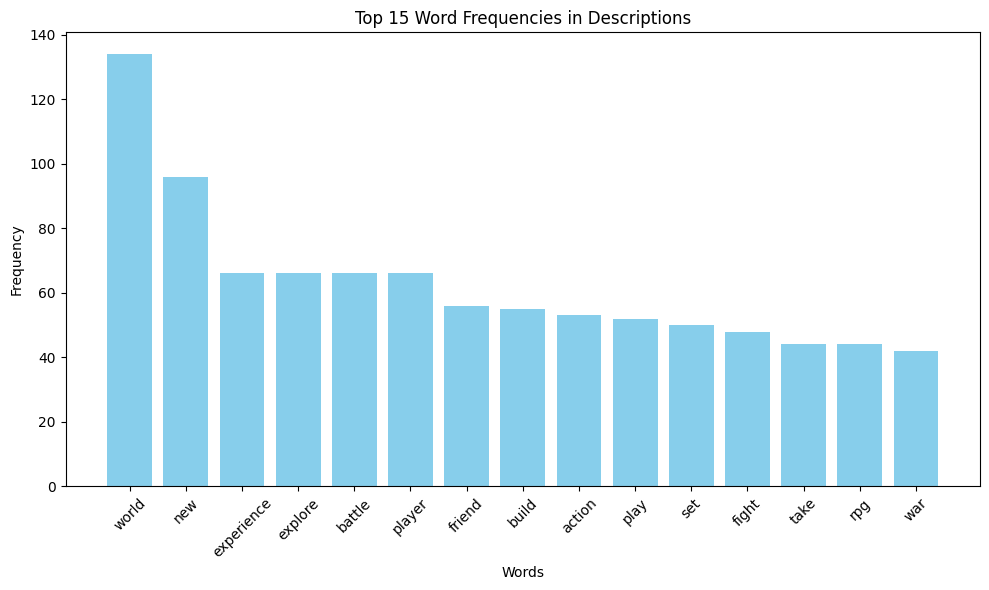

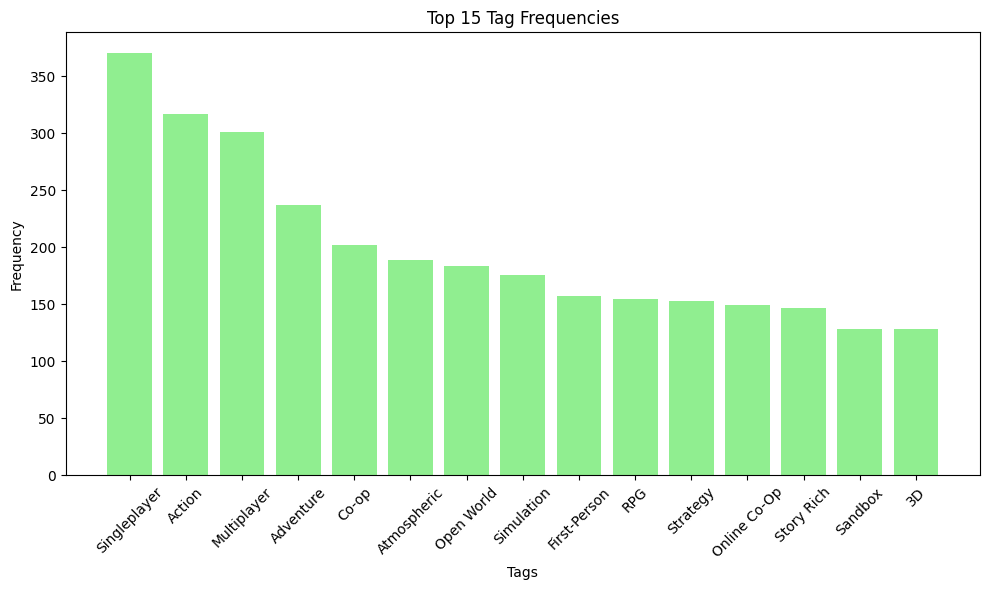

In [39]:
df['Preprocessed_Description'] = df['Description'].apply(clean_text)
df['Preprocessed_Title'] = df['Title'].apply(clean_title)
modified_df = analyze_game_data(df, top_n_words=15, top_n_tags=15)
df.to_csv("Intermediate\\modified_steam_games.csv", index=False)

## Wordcloud

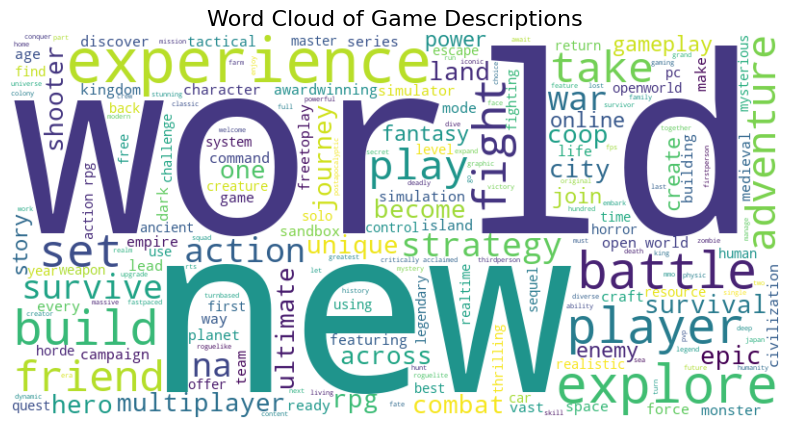

In [42]:
create_wordcloud(list(modified_df['Tokenized_Description']))

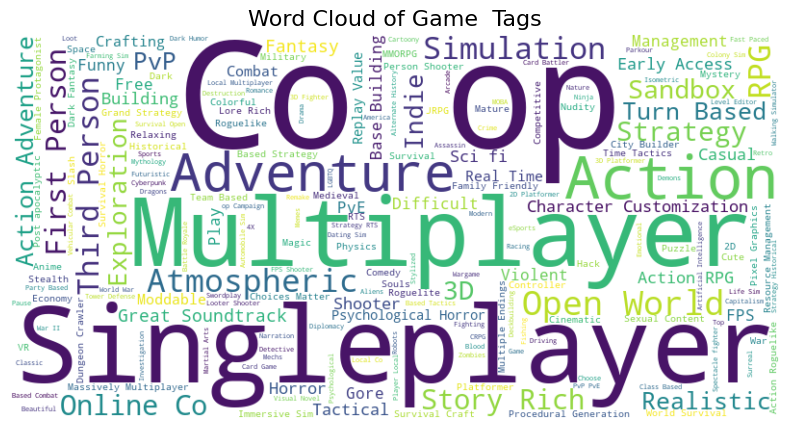

In [49]:
create_wordcloud(modified_df['Tags'].apply(safely_convert_to_list),title="Tags")

# Previous Related Work

* [Web Scraping](https://github.com/Rajat72/Web-scrapper-game)
* [Data Analysis](https://github.com/Rajat72/Data-Analysis)

# Standard followed in this project

* Usage of logging instead of print statement, as it has many level, and is used in production ready software
* try-except block where ever possible